# FiberNet: effect of pacing location in 3D model

In this notebook we compare different pacing strategies to infer the fiber directions in the 3D model:
1. Pacing from coronary sinus (CS) distal and proximal (2 maps in total);
2. Pacing from CS distal and in the area of the Bachmann's bundle (2 maps);
3. Pacing from CS distal, proximal and in the area of the Bachmann's bundle (3 maps).

The CS is easy to reach during the clinical mapping, and the Bachmann's bundle should resemble the sinus activation.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pyvista as pv
import vtk
import tensorflow as tf
from matplotlib import cm
from FiberNetModels_3D import SyntheticDataGenerator3D, MultiAnisoEikonalPINN_3D 
#pv.set_jupyter_backend("panel") # If you want interactive 3D plots
pv.set_jupyter_backend("static")

Import of Cupy failed. The GPU version of fimpy will be unavailble. Message: No module named 'cupy'


In [2]:
def do_training():
    np.random.seed(0)
    tf.random.set_seed(0)
    layers = [3] + [20] * 7 + [1]
    CVlayers = [3] + [20] * 7 + [3]

    vtk_f = pv.UnstructuredGrid(geometry_file)
    points = vtk_f.points
    triangs = vtk_f.cells_dict[vtk.VTK_TRIANGLE]
    l = vtk_f.cell_data["fibers"]

    smooth_basis_file = geometry_file[:-4] + '_smooth_basis.vtk'

    synthetic_values = SyntheticDataGenerator3D(geometry_file, maps=maps, ppm=sample_points//len(maps), noise=noise_ms)
    real_times, sample_times, sample_coords, measurement_mask, fiber_vecs_3D, indices = synthetic_values.get_values()

    model = MultiAnisoEikonalPINN_3D(points, triangs, maps_number, sample_coords, 
                                    sample_times, indices, layers, CVlayers, 
                                    smooth_basis_file=smooth_basis_file,
                                    CVmax=3.0, lambda_df=1.e0, lambda_pde=1.e-4, 
                                    lambda_tve=1.e-5, lambda_tva=1.e-9, 
                                    jobs=4)

    # Model training
    loss_curve = model.train_Adam_minibatch(int(1e3), size=32)
    predicted_times, cv, dcv, D_2D, D_3D, evals, evecs, eik_mismatch = model.predict(points)

    centroids = (points[triangs[:,0],:] + points[triangs[:,1],:] + points[triangs[:,2],:])/3.
    D_cen_3D = model.predict(centroids)[4] # Model values at centroids
    predicted_vals_3D, predicted_vecs_3D = np.linalg.eigh(D_cen_3D)

    D_mismatch_rad = np.arccos(np.clip(np.abs(np.sum(fiber_vecs_3D[..., :, 2]*predicted_vecs_3D[..., :, 2],1)),0.,1.))
    fiber_orientation_error = np.rad2deg(np.mean(D_mismatch_rad))
    D_mismatch_degree = np.rad2deg(D_mismatch_rad)
    D_mismatch_degree_dist = np.rad2deg(np.percentile(D_mismatch_rad, [25,50,75]))

    data_fidelity_error = np.sqrt(np.mean((predicted_times-real_times)**2))
    mesh = pv.UnstructuredGrid({vtk.VTK_TRIANGLE: triangs}, points)
    mesh.point_data["act_times"] = predicted_times
    mesh.point_data["eik_mismatch"] = eik_mismatch
    mesh.cell_data["fiber_err"] = D_mismatch_degree
    mesh.cell_data["fibers"] = predicted_vecs_3D[..., :, 2]
    #mesh.save("output.vtk") #Results can be saved to the disk and viewed in other software like Paraview

    model.sess.close()
    tf.compat.v1.reset_default_graph()

    return mesh, real_times, fiber_orientation_error, data_fidelity_error

def do_plot(mesh, real_times, fiber_orientation_error, data_fidelity_error):
    cmap = cm.get_cmap("inferno", 20)

    bedges = mesh.extract_feature_edges(feature_edges=False,boundary_edges=True,manifold_edges=False)

    plotter = pv.Plotter(window_size=(1600, 700), shape=(1, 2))
    plotter.subplot(0, 0)
    plotter.add_mesh(mesh, show_scalar_bar=False, color="w")
    glyphs = mesh.cell_data_to_point_data().glyph(orient="fibers", scale=False, factor=2)
    glyphs.set_active_scalars("fiber_err")
    plotter.add_mesh(glyphs, cmap=cmap, show_scalar_bar=False, clim=[0,90])
    plotter.add_mesh(bedges, color="red", line_width=5)
    plotter.camera.position = [34.90010739823705, -120.06186620991983, -69.20885085393053]
    plotter.camera.focal_point = [4.318968801436604, -9.099057508859794, 11.316830437617247]
    plotter.camera.up = [-0.23149304827623654, 0.5287886763913683, -0.8165742491164174]
    plotter.camera.parallel_scale = 53.2299
    plotter.add_text("Posterior",font_size=14)
    #plotter.add_camera_orientation_widget()
    for pp in mesh.points[real_times.argmin(axis=0),:]:
        sph = pv.Sphere(radius=1, center=pp)
        plotter.add_mesh(sph,smooth_shading=True,color='blue')

    plotter.subplot(0, 1)
    plotter.camera.position = [-65.16720771058229, 103.97243886022419, 65.96968260082595]
    plotter.camera.focal_point = [8.569376850316937, -1.10271544535806, 8.921769885950457]
    plotter.camera.up = [-0.31968827697870306, 0.26893578053171824, -0.9085554201655415]
    plotter.camera.parallel_scale = 53.2299
    plotter.add_mesh(mesh, show_scalar_bar=True, color="w")
    plotter.add_mesh(bedges, color="red", line_width=5)
    for pp in mesh.points[real_times.argmin(axis=0),:]:
        sph = pv.Sphere(radius=1, center=pp)
        plotter.add_mesh(sph,smooth_shading=True,color='blue')
    plotter.add_mesh(glyphs, cmap=cmap, show_scalar_bar=False, clim=[0,90])
    plotter.add_text("Anterior",font_size=14)
    plotter.add_scalar_bar('Fiber error', vertical=False,
                        title_font_size=16,
                        label_font_size=16,
                        position_x=0.1,
                        n_labels=10,
                        fmt='%5.0f°')

    plotter.add_text(f"Number of maps: {maps_number}\n"\
        f"Mean fiber error: {fiber_orientation_error:.3g}°\n"\
        f"RMSE data fidelity: {data_fidelity_error:.3g} ms",font_size=10,position='upper_right')

    plotter.show()

In [3]:
#@title Inputs
# These data files are 3D meshes with data
geometry_file = "./data/LA_model.vtk" # .vtk
CS_dist,CS_prox,BB = 6099,668,6004  # ids of vertices
sample_points = 1020 #@param {type:"slider", min:1, max:1500, step:1}
noise_ms = 0.0 #@param {type:"slider", min:0.0, max:5.0, step:0.1}

print(f"Selected values -> file: {geometry_file}, sample points: {sample_points}, noise (ms): {noise_ms}" )

Selected values -> file: ./data/LA_model.vtk, sample points: 1020, noise (ms): 0.0


## Case 1: CS dist + CS prox

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

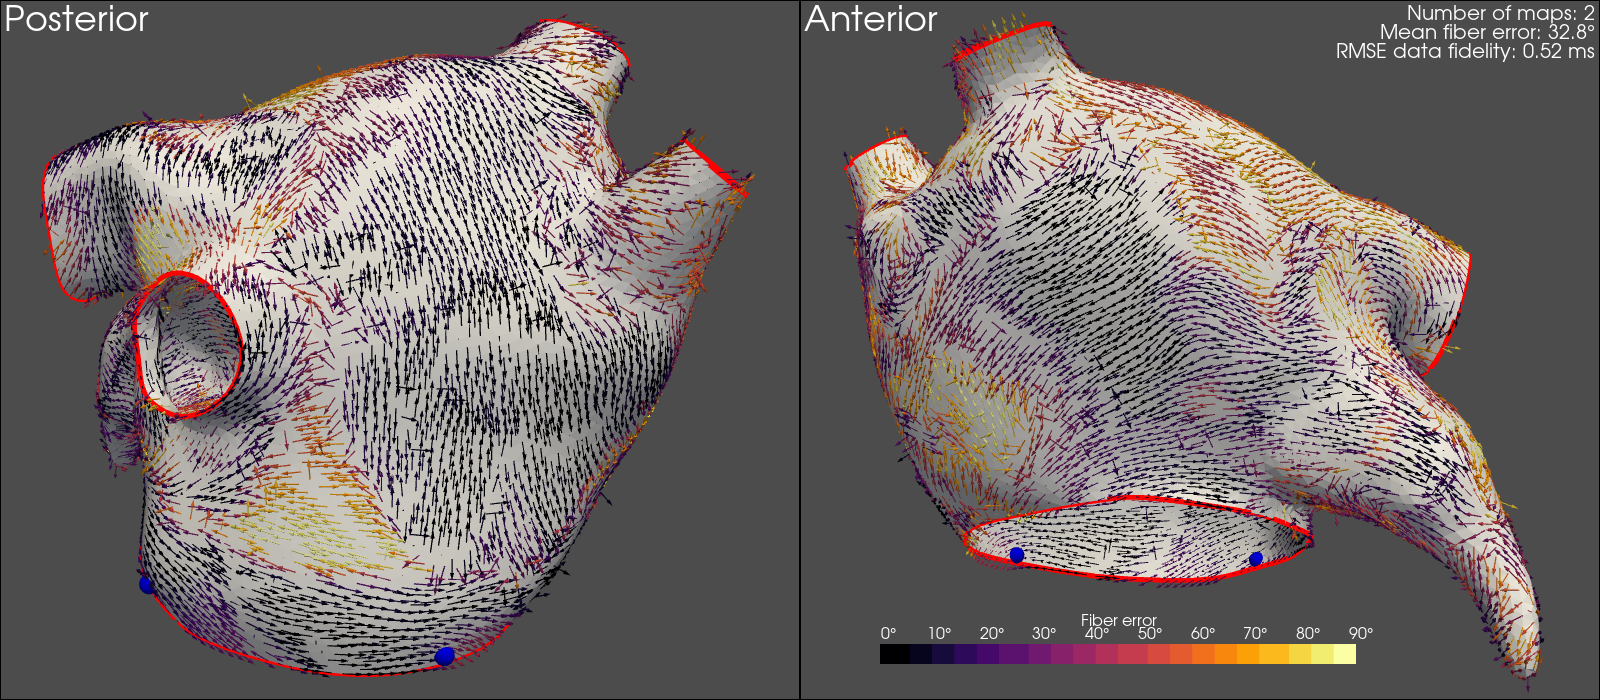

In [4]:
maps = [CS_dist, CS_prox]
maps_number = len(maps)

do_plot(*do_training())

## Case 2: CS dist + SR

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

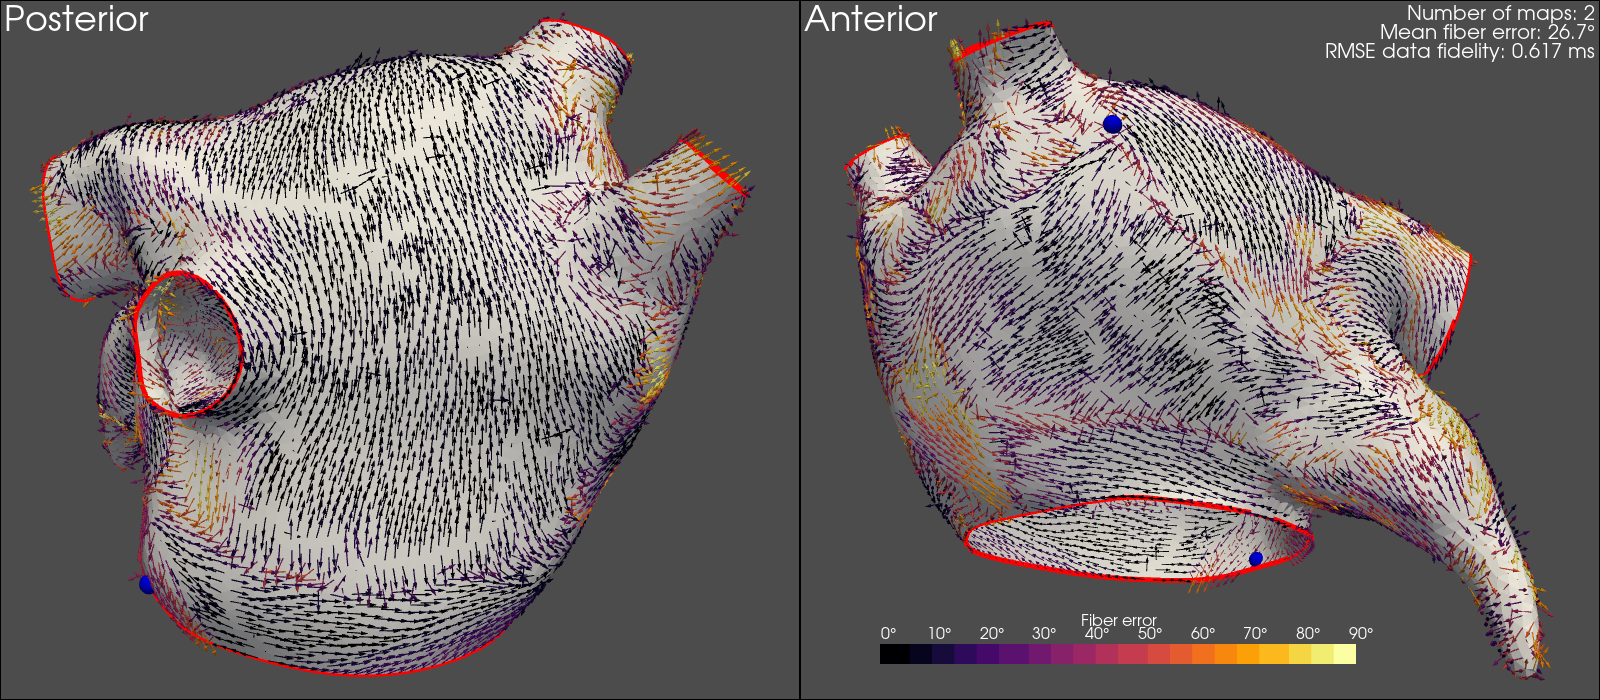

In [5]:
maps = [CS_dist, BB]
maps_number = len(maps)

do_plot(*do_training())

## Case 3: CS dist + CS prox + SR

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

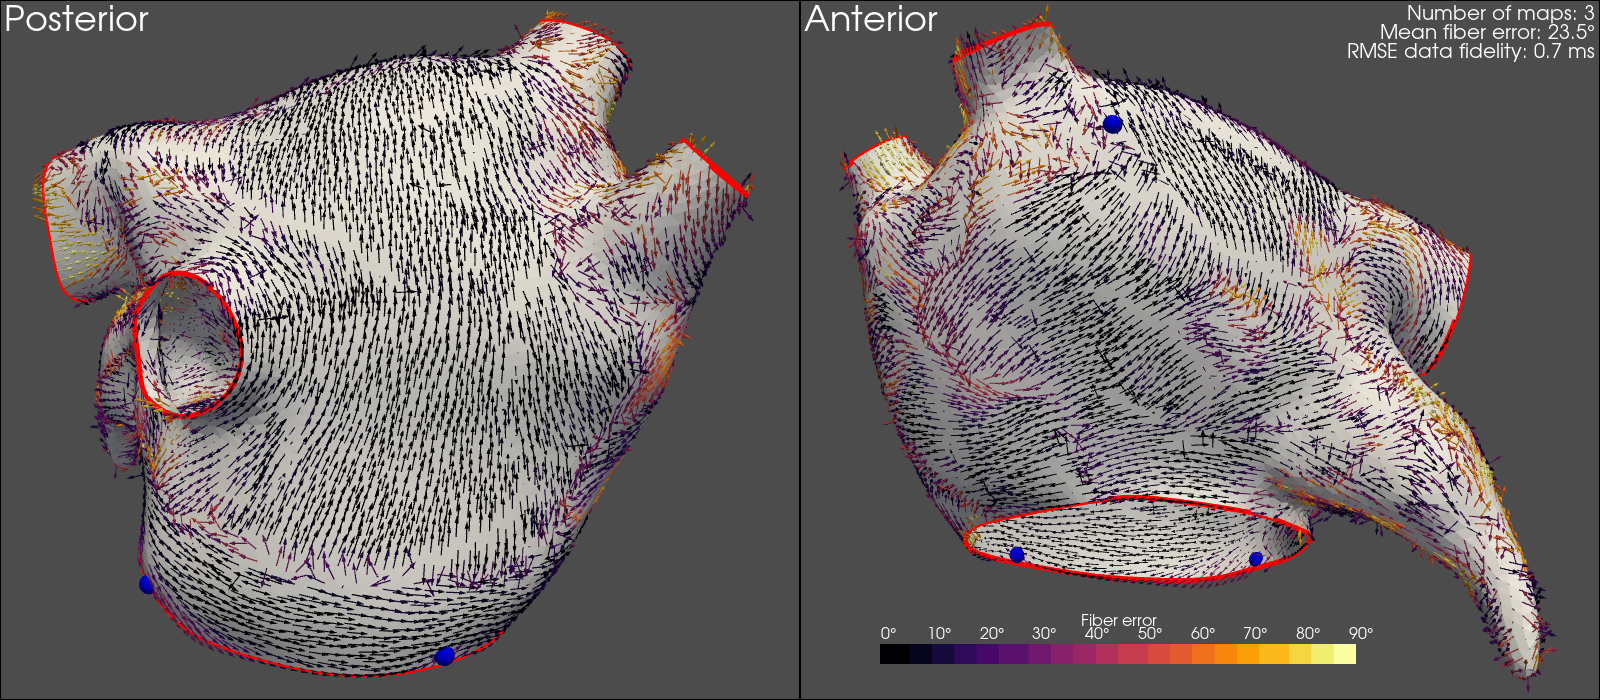

In [6]:
maps = [CS_dist, CS_prox, BB]
maps_number = len(maps)

do_plot(*do_training())